<a href="https://colab.research.google.com/github/DiwasGurung/C-PokheraliDevelopers/blob/main/Nepse%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accuracy: 0.5410071942446043
              precision    recall  f1-score   support

           0       0.58      0.80      0.67       809
           1       0.39      0.17      0.24       581

    accuracy                           0.54      1390
   macro avg       0.48      0.49      0.46      1390
weighted avg       0.50      0.54      0.49      1390

📉 Prediction: Price will go DOWN or stay flat tomorrow


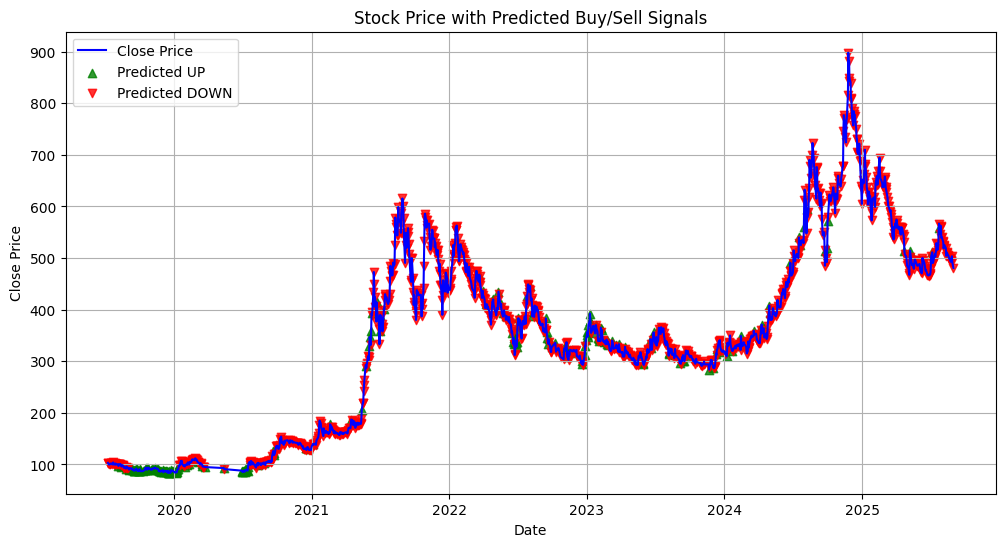

In [18]:
# nepse_trend_prediction_with_plots.py

import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_csv("BFC.csv", parse_dates=["published_date"])
df = df.sort_values("published_date").reset_index(drop=True)

# 2. Clean numeric columns
for col in ["open", "high", "low", "close", "per_change", "traded_quantity", "traded_amount"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["close"])

# 3. Create target (1 = price up tomorrow, 0 = down/flat)
df["target"] = (df["close"].shift(-1) > df["close"]).astype(int)

# 4. Features
df["return"] = df["close"].pct_change()
df["rolling_mean_5"] = df["close"].rolling(5).mean()
df["rolling_mean_10"] = df["close"].rolling(10).mean()
df["rolling_std_5"] = df["close"].rolling(5).std()
df["volume_change"] = df["traded_quantity"].pct_change()
df = df.dropna()

features = [
    "open", "high", "low", "close",
    "per_change", "traded_quantity", "traded_amount",
    "return", "rolling_mean_5", "rolling_mean_10",
    "rolling_std_5", "volume_change"
]

X = df[features]
y = df["target"]

# 5. Time series training & prediction
tscv = TimeSeriesSplit(n_splits=5)
all_preds, all_true = [], []
model = RandomForestClassifier(n_estimators=300, max_depth=8, random_state=42)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    all_preds.extend(preds)
    all_true.extend(y_test)

# 6. Evaluation
print("Accuracy:", accuracy_score(all_true, all_preds))
print(classification_report(all_true, all_preds))

# 7. Attach predictions to dataframe
df_results = df.iloc[-len(all_preds):].copy()
df_results["Predicted"] = all_preds
df_results["Actual"] = all_true

# 8. Predict tomorrow’s signal
latest_data = X.iloc[[-1]]
next_day_signal = model.predict(latest_data)[0]
if next_day_signal == 1:
    print("📈 Prediction: Price will go UP tomorrow")
else:
    print("📉 Prediction: Price will go DOWN or stay flat tomorrow")

# 9. Plot stock price with signals
plt.figure(figsize=(12,6))
plt.plot(df_results["published_date"], df_results["close"], label="Close Price", color="blue")

# Plot UP signals (Predicted=1) as green arrows
up_signals = df_results[df_results["Predicted"] == 1]
plt.scatter(up_signals["published_date"], up_signals["close"],
            label="Predicted UP", marker="^", color="green", alpha=0.8)

# Plot DOWN signals (Predicted=0) as red arrows
down_signals = df_results[df_results["Predicted"] == 0]
plt.scatter(down_signals["published_date"], down_signals["close"],
            label="Predicted DOWN", marker="v", color="red", alpha=0.8)

plt.title("Stock Price with Predicted Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()
